In [146]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters

In [147]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

In [148]:
slrtbl = ascii.read('../3.table/smass/solar.csv')
slrtbl

nm,W/sm/nm,W/sm
float64,float64,float64
199.5,0.005,0.005498
200.5,0.007,0.01253
201.5,0.007,0.01971
202.5,0.008,0.02758
203.5,0.009,0.03629
204.5,0.009,0.04575
205.5,0.01,0.05531
206.5,0.01,0.06549
207.5,0.011,0.07696


Text(0, 0.5, 'W/sm/nm')

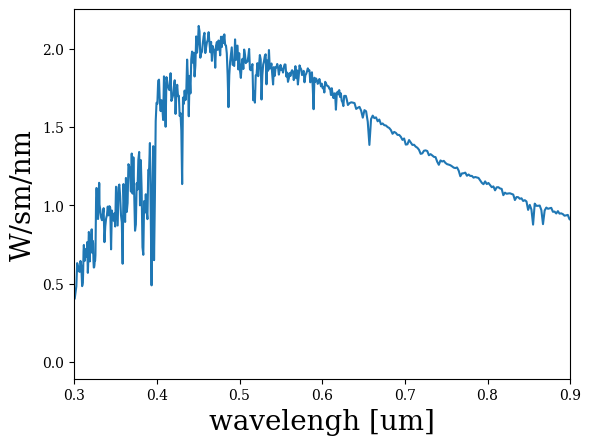

In [149]:
plt.plot(slrtbl['nm']*1e-3, slrtbl['W/sm/nm'])
plt.xlim([0.3, 0.9])

plt.xlabel('wavelengh [um]')
plt.ylabel('W/sm/nm')

1. col1 : wavelength [um]
2. col2 : relative reflectance [0.5um as 1]
3. col3 : error
4. col4 : flag

In [150]:
intbl = ascii.read('../3.table/smass/a000433.sp256n2.txt')
intbl

col1,col2,col3,col4
float64,float64,float64,int64
0.435,0.7756,0.0116,1
0.4375,0.7901,0.0103,1
0.44,0.7805,0.0092,1
0.4425,0.7942,0.0081,1
0.445,0.8028,0.0072,1
0.4475,0.7978,0.0065,1
0.45,0.802,0.0058,1
0.4525,0.8158,0.0053,1
0.455,0.8143,0.005,1


Text(0, 0.5, 'Normalized reflectance')

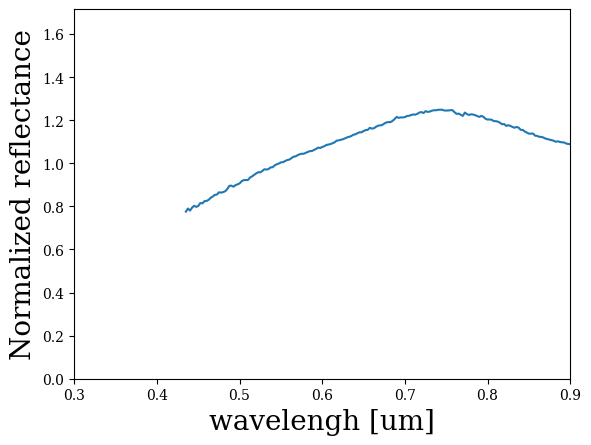

In [151]:
fintbl = intbl[intbl['col4']==1]
plt.plot(fintbl['col1'], fintbl['col2'])
plt.xlim([0.3, 0.9])
yl, yu = plt.ylim()
plt.ylim([0, yu])

plt.xlabel('wavelengh [um]')
plt.ylabel('Normalized reflectance')

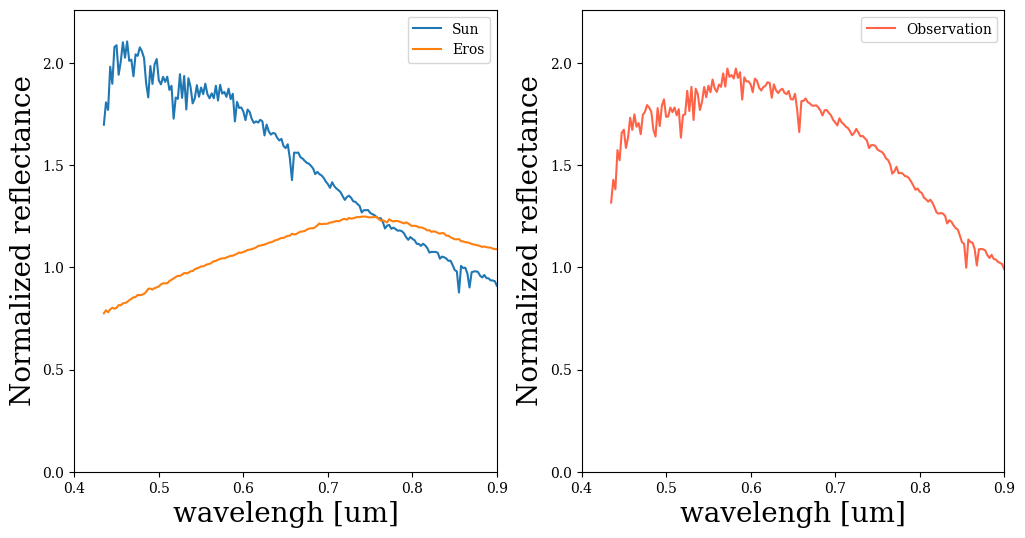

In [152]:
iy = np.interp(fintbl['col1'], slrtbl['nm']*1e-3, slrtbl['W/sm/nm'])

fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fintbl['col1'], iy, label='Sun')
plt.plot(fintbl['col1'], fintbl['col2'], label='Eros')

plt.xlim([0.4, 0.9])
yl, yu = plt.ylim()
plt.ylim([0, yu])

plt.legend()
plt.xlabel('wavelengh [um]')
plt.ylabel('Normalized reflectance')

plt.subplot(1, 2, 2)
yobs = fintbl['col2']*iy
plt.plot(fintbl['col1'], yobs, c='tomato', label='Observation')
plt.legend()

plt.xlim([0.4, 0.9])
plt.ylim([0, yu])

plt.xlabel('wavelengh [um]')
plt.ylabel('Normalized reflectance')

plt.savefig('../4.plot/test.eros.spectrum.png')

# Synphot

In [95]:
rsptbl = ascii.read('../3.table/kmtnet/kmtnet_filter.csv')
rsptbl

# filterlist = np.unique(rsptbl.keys()[1:])
# filterlist = ['B', 'V', 'R', 'I']
filterlist = ['V',]
for filte in filterlist:


	rsp = rsptbl[filte]
	rsp = rsp*1e-2 # [%] --> [0.0-1.0]
	rsp[0] = 0.0
	rsp[-1] = 0.0
	rsp[rsp<0] = 0.0

	index = np.where(
		rsp>0.1		
	)
	
	rsp0 = rsp[index]
	rsp0[0] = 0.0
	rsp0[-1] = 0.0

	#	Filter Table
	_ = speclite.filters.FilterResponse(
		wavelength = rsptbl['wavelength'][index]*u.nm,
		response = rsp0, meta=dict(group_name='kmtnet', band_name=filte)
	)

#	New name for speclite class
kfilterlist = [f"kmtnet-{filte}" for filte in filterlist]

#	KMTNet filters
kmtns = speclite.filters.load_filters(*kfilterlist)

In [96]:
kmtns.effective_wavelengths

<Quantity [5558.30284329] Angstrom>

In [97]:
rsptbl = ascii.read('../3.table/7dt.filter.response.realistic_optics.ecsv')

filterlist = np.unique(rsptbl['name'])
#	Remove m400
filterlist = filterlist[5:]

for filte in filterlist:
	#	Filter Table
	fltbl = rsptbl[rsptbl['name']==filte]

	_ = speclite.filters.FilterResponse(
		wavelength = fltbl['lam'],
		response = fltbl['response'], meta=dict(group_name='med', band_name=filte)
	)

#	New name for speclite class
mfilterlist = [f"med-{filte}" for filte in filterlist]

#	Medium filters
meds = speclite.filters.load_filters(*mfilterlist)
meds

In [98]:
lam = fintbl['col1']*u.um
flam = yobs*(u.erg/u.second/u.Angstrom/(u.cm**2))

In [122]:
mags0 = meds.get_ab_magnitudes(
	flam,
	lam
)

mags = meds.get_ab_magnitudes(
	flam,
	lam
).as_array()

kmags0 = kmtns.get_ab_magnitudes(
	flam,
	lam
)

kmags = kmtns.get_ab_magnitudes(
	flam,
	lam
).as_array()

kmags0

appVmag = 16

offset = appVmag-kmags0['kmtnet-V']
print(offset)

     kmtnet-V    
-----------------
37.80321309407036


(-21.603454124974988, -22.308623005161422)

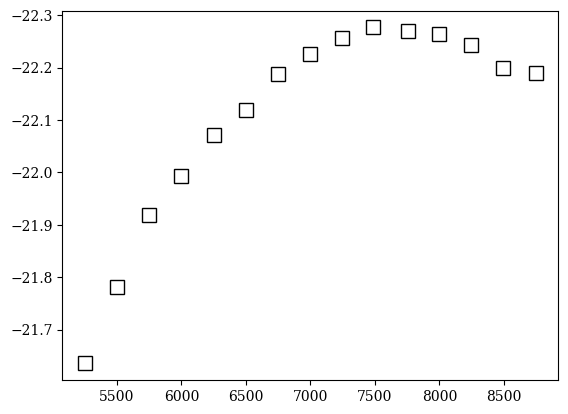

In [123]:
plt.plot(meds.effective_wavelengths, mags.item(), marker='s', mec='k', mfc='none', ms=10, ls='none',)

yl, yu = plt.ylim()
plt.ylim([yu, yl])

In [124]:
sdtbl = ascii.read(f"../3.table/7dt.filter.realistic_optics.180s.summary.ecsv")
sdtbl

index,name,center_wavelength,fwhm,min_wavelength,max_wavelength,noise_countrate,surface_brightness,5sigma_depth
,,Angstrom,Angstrom,Angstrom,Angstrom,electron / s,mag / arcsec2,mag
int64,str4,float64,float64,float64,float64,float64,float64,float64
0,m400,4000.0,250.0,3875.0,4125.0,0.1455,20.73,20.81
1,m425,4250.0,250.0,4125.0,4375.0,0.2042,20.85,20.93
2,m450,4500.0,250.0,4375.0,4625.0,0.2812,20.89,20.97
3,m475,4750.0,250.0,4625.0,4875.0,0.3164,20.92,21
4,m500,5000.0,250.0,4875.0,5125.0,0.3244,20.93,21.02
5,m525,5250.0,250.0,5125.0,5375.0,0.3093,20.88,20.97
6,m550,5500.0,250.0,5375.0,5625.0,0.3792,20.7,20.78
7,m575,5750.0,250.0,5625.0,5875.0,0.286,20.71,20.8


In [125]:
def calc_snr(m1, m2):
	"""
	m2 : 5 sigma depth
	"""
	snr = 5*10**((m2-m1)/5)
	return snr

In [126]:
calc_snr(15, 20)

50.0

In [127]:
mlist = []
merrlist = []
snrlist = []

for filte in filterlist:
	depth = sdtbl['5sigma_depth'][sdtbl['name']==filte].item()
	m = mags0[f'med-{filte}'][0]+offset.item()
	snr = calc_snr(m, depth).item()
	# print(filte, depth, m, 1/snr, snr)
	print(f"{filte} {m:1.3f}+/-{1/snr:1.3f} ({snr:1.1f})")

	mlist.append(m)
	merrlist.append(1/snr)
	snrlist.append(snr)


m525 16.168+/-0.022 (45.6)
m550 16.022+/-0.022 (44.7)
m575 15.884+/-0.021 (48.0)
m600 15.810+/-0.021 (47.3)
m625 15.732+/-0.022 (44.9)
m650 15.684+/-0.022 (46.0)
m675 15.616+/-0.022 (45.5)
m700 15.578+/-0.023 (43.3)
m725 15.546+/-0.026 (38.0)
m750 15.527+/-0.028 (36.0)
m775 15.533+/-0.034 (29.7)
m800 15.538+/-0.036 (27.6)
m825 15.560+/-0.041 (24.5)
m850 15.603+/-0.046 (21.5)
m875 15.614+/-0.055 (18.3)


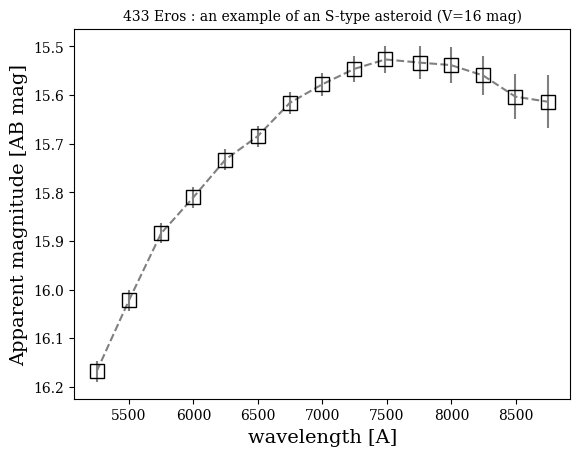

In [153]:
plt.errorbar(meds.effective_wavelengths, y=mlist, yerr=merrlist, ls='--', marker='s', mec='k', mfc='none', ms=10, c='grey')

yl, yu = plt.ylim()
plt.ylim([yu, yl])
plt.xlabel('wavelength [A]', fontsize=14)
plt.ylabel('Apparent magnitude [AB mag]', fontsize=14)
plt.title(f'433 Eros : an example of an S-type asteroid (V={appVmag} mag)', fontsize=10)
plt.savefig('../4.plot/test.eros.7dt.synphot.png')